# Domain Adaptation (SVHN to MNIST)

Innopolis University, 2019 <br>
Introduction to Machine Learning <br>

Gleb Petrakov <br>
g.petrakov@innopolis.ru <br>

## Sources

Maximum Classifier Discrepancy for Unsupervised Domain Adaptation <br>
Kuniaki Saito, Kohei Watanabe, Yoshitaka Ushiku, Tatsuya Harada <br>

https://arxiv.org/abs/1712.02560

https://github.com/mil-tokyo/MCD_DA

In [1]:
from __future__ import print_function

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.FATAL)

import argparse, random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

### Arguments
Tune hyperparameters here

In [2]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=20, metavar='N',
                    help='number of epochs to train (default: 20)')
parser.add_argument('--num-k', type=int, default=4, metavar='N',
                    help='hyper paremeter for generator update')
parser.add_argument('--lr', type=float, default=0.0001, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='how many batches to wait before logging training status')

parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
args = parser.parse_args([])

### Initialization
To be sure results are consistent, push seeds to everyting

In [3]:
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

### Dataset
Using SVHN and MNIST datasets with PyTorch Dataloaders

In [4]:
svhn_train_loader = torch.utils.data.DataLoader(
    datasets.SVHN('./data/data_svhn', split='train', download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.batch_size, drop_last=True, shuffle=True, **kwargs)

svhn_test_loader = torch.utils.data.DataLoader(
    datasets.SVHN('./data/data_svhn', split='test', download=True,
                  transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.test_batch_size, drop_last=True, shuffle=True, **kwargs)

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/data_mnist', train=True, download=True,
                  transform=transforms.Compose([
                       transforms.Resize((32,32)),
                       transforms.Grayscale(num_output_channels=3), 
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.batch_size, drop_last=True, shuffle=True, **kwargs)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/data_mnist', train=False, download=True,
                  transform=transforms.Compose([
                       transforms.Resize((32,32)),
                       transforms.Grayscale(num_output_channels=3), 
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.test_batch_size, drop_last=True, shuffle=True, **kwargs)

  0%|          | 65536/182040794 [00:00<05:03, 599171.92it/s]

182042624it [00:02, 89257236.75it/s]                               
  0%|          | 32768/64275384 [00:00<03:36, 297043.92it/s]

64282624it [00:01, 54070401.39it/s]                             
0it [00:00, ?it/s]

9920512it [00:01, 9228513.84it/s]                            


Extracting ./data/data_mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/data_mnist/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 101308.49it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/data_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/data_mnist/MNIST/raw


1654784it [00:00, 2284090.94it/s]                            
0it [00:00, ?it/s]

Extracting ./data/data_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/data_mnist/MNIST/raw


8192it [00:00, 34013.08it/s]            

Extracting ./data/data_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/data_mnist/MNIST/raw
Processing...
Done!


### Feature
The geenrator part

In [5]:
class Feature(nn.Module):
    def __init__(self):
        super(Feature, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(8192, 3072)
        self.bn1_fc = nn.BatchNorm1d(3072)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), stride=2, kernel_size=3, padding=1)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), stride=2, kernel_size=3, padding=1)
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), 8192)
        x = F.relu(self.bn1_fc(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        return x

### Predictor
The prediction part

In [6]:
class Predictor(nn.Module):
    def __init__(self, prob=0.5):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(8192, 3072)
        self.bn1_fc = nn.BatchNorm1d(3072)
        self.fc2 = nn.Linear(3072, 2048)
        self.bn2_fc = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048, 10)
        self.bn_fc3 = nn.BatchNorm1d(10)
        self.prob = prob

    def forward(self, x):
        x = F.relu(self.bn2_fc(self.fc2(x)))
        x = self.fc3(x)
        return x

### Model initialization

In [7]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.xavier_normal(m.weight)
    if type(m) == nn.Linear:
        nn.init.xavier_normal(m.weight)

In [8]:
G = Feature().apply(init_weights).to(device)
C1 = Predictor().apply(init_weights).to(device)
C2 = Predictor().apply(init_weights).to(device)

In [9]:
opt_G = optim.Adam(G.parameters(),lr=args.lr, weight_decay=0.0005)
opt_C1 = optim.Adam(C1.parameters(), lr=args.lr, weight_decay=0.0005)
opt_C2 = optim.Adam(C2.parameters(), lr=args.lr, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

### Train

In [10]:
def train():
    G.train()
    C1.train()
    C2.train()
    
    def reset_grad():
        opt_G.zero_grad()
        opt_C1.zero_grad()
        opt_C2.zero_grad()
    
    def discrepancy(out1, out2):
        return torch.mean(torch.abs(F.softmax(out1)- F.softmax(out2)))

    data_zip = enumerate(zip(svhn_train_loader, mnist_train_loader))
    for batch_idx, ((img_s, label_s), (img_t,_)) in data_zip:
        img_t = img_t.to(device)
        img_s = img_s.to(device)
        label_s = label_s.to(device)
        
        reset_grad()
        feat_s = G(img_s)
        output_s1 = C1(feat_s)
        output_s2 = C2(feat_s)
        
        loss_s1 = criterion(output_s1, label_s)
        loss_s2 = criterion(output_s2, label_s)
        loss_s = loss_s1 + loss_s2
        
        loss_s.backward()
        opt_G.step()
        opt_C1.step()
        opt_C2.step()
        
        reset_grad()
        feat_s = G(img_s)
        output_s1 = C1(feat_s)
        output_s2 = C2(feat_s)
        feat_t = G(img_t)
        output_t1 = C1(feat_t)
        output_t2 = C2(feat_t)
        
        loss_s1 = criterion(output_s1, label_s)
        loss_s2 = criterion(output_s2, label_s)
        loss_s = loss_s1 + loss_s2
        loss_dis = discrepancy(output_t1, output_t2)
        loss = loss_s - loss_dis
        
        loss.backward()
        opt_C1.step()
        opt_C2.step()
        
        reset_grad()
        
        for i in range(args.num_k):
            feature_t = G(img_t)
            output_t1 = C1(feature_t)
            output_t2 = C2(feature_t)
            loss_dis = discrepancy(output_t1, output_t2)
            loss_dis.backward()
            opt_G.step()
            reset_grad()
        
        if (batch_idx + 1) % args.log_interval == 0:
            print("Epoch: {}/{} [{}/{}]: Loss1: {:.5f}, Loss2: {:.5f}, Discrepancy: {:.5f}"
                 .format(epoch + 1, args.epochs, batch_idx + 1, min(len(svhn_train_loader), len(mnist_train_loader)), 
                         loss_s1.item(), loss_s2.item(), loss_dis.item()))

### Test

In [11]:
list_acc_mnist_train = []
list_acc_svhn_train = []
list_acc_svhn_test = []

def test():
    G.eval()
    C1.eval()
    C2.eval()


    correct = 0
    
    for (img_s, label_s) in mnist_test_loader:
        img_s = img_s.to(device)
        label_s = label_s.to(device)
        
        feat = G(img_s)
        output1 = C1(feat)
        output2 = C2(feat)
        
        output_ensemble = output1 + output2
        pred_ensemble = output_ensemble.data.max(1)[1]
        
        correct += pred_ensemble.eq(label_s.data).cpu().sum()
        
    acc_mnist_train = 100. * correct / len(mnist_test_loader.dataset)
    
    
    correct = 0
    
    for (img_s, label_s) in svhn_train_loader:
        img_s = img_s.to(device)
        label_s = label_s.to(device)
        
        feat = G(img_s)
        output1 = C1(feat)
        output2 = C2(feat)
        
        output_ensemble = output1 + output2
        pred_ensemble = output_ensemble.data.max(1)[1]
        
        correct += pred_ensemble.eq(label_s.data).cpu().sum()
    
    acc_svhn_train = 100. * correct / len(svhn_train_loader.dataset)
    
    
    correct = 0
    
    for (img_s, label_s) in svhn_test_loader:
        img_s = img_s.to(device)
        label_s = label_s.to(device)
        
        feat = G(img_s)
        output1 = C1(feat)
        output2 = C2(feat)
        
        output_ensemble = output1 + output2
        pred_ensemble = output_ensemble.data.max(1)[1]
        
        correct += pred_ensemble.eq(label_s.data).cpu().sum()
    
    acc_svhn_test = 100. * correct / len(svhn_test_loader.dataset)
        
    print(
        '\nTest: MNIST Test: {:.0f}%, SVHN Train: {:.0f}%, SVHN Test: {:.0f}% \n'.format(
            acc_mnist_train, acc_svhn_train, acc_svhn_test))
    list_acc_mnist_train.append(acc_mnist_train)
    list_acc_svhn_train.append(acc_svhn_train)
    list_acc_svhn_test.append(acc_svhn_test)

### Main

In [12]:
for epoch in range(args.epochs):
    train()
    test()

Epoch: 1/20 [100/468]: Loss1: 0.48013, Loss2: 0.46642, Discrepancy: 0.01412
Epoch: 1/20 [200/468]: Loss1: 0.43323, Loss2: 0.44460, Discrepancy: 0.01302
Epoch: 1/20 [300/468]: Loss1: 0.31360, Loss2: 0.35238, Discrepancy: 0.01034
Epoch: 1/20 [400/468]: Loss1: 0.39734, Loss2: 0.36853, Discrepancy: 0.00811

Test: MNIST Test: 80%, SVHN Train: 53%, SVHN Test: 53% 

Epoch: 2/20 [100/468]: Loss1: 0.35029, Loss2: 0.36453, Discrepancy: 0.00608
Epoch: 2/20 [200/468]: Loss1: 0.20641, Loss2: 0.21610, Discrepancy: 0.00495
Epoch: 2/20 [300/468]: Loss1: 0.27683, Loss2: 0.26658, Discrepancy: 0.00658
Epoch: 2/20 [400/468]: Loss1: 0.33804, Loss2: 0.32718, Discrepancy: 0.00470

Test: MNIST Test: 82%, SVHN Train: 68%, SVHN Test: 67% 

Epoch: 3/20 [100/468]: Loss1: 0.18715, Loss2: 0.18048, Discrepancy: 0.00409
Epoch: 3/20 [200/468]: Loss1: 0.19343, Loss2: 0.19267, Discrepancy: 0.00550
Epoch: 3/20 [300/468]: Loss1: 0.16113, Loss2: 0.16693, Discrepancy: 0.00413
Epoch: 3/20 [400/468]: Loss1: 0.17858, Loss2: 0.

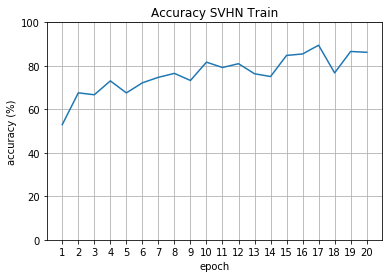

In [13]:
fig, ax = plt.subplots()
ax.plot(range(1, args.epochs + 1), list_acc_svhn_train)
ax.set(xlabel='epoch', ylabel='accuracy (%)',
       title='Accuracy SVHN Train')
ax.set_ylim(0, 100)
ax.grid()
plt.xticks(range(1, args.epochs + 1))
plt.show()

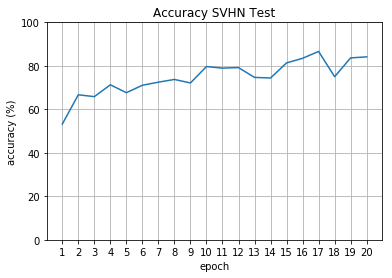

In [14]:
fig, ax = plt.subplots()
ax.plot(range(1, args.epochs + 1), list_acc_svhn_test)
ax.set(xlabel='epoch', ylabel='accuracy (%)',
       title='Accuracy SVHN Test')
ax.set_ylim(0, 100)
ax.grid()
plt.xticks(range(1, args.epochs + 1))
plt.show()

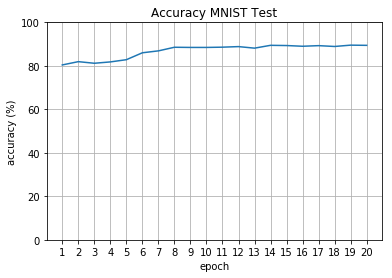

In [15]:
fig, ax = plt.subplots()
ax.plot(range(1, args.epochs + 1), list_acc_mnist_train)
ax.set(xlabel='epoch', ylabel='accuracy (%)',
       title='Accuracy MNIST Test')
ax.set_ylim(0, 100)
ax.grid()
plt.xticks(range(1, args.epochs + 1))
plt.show()